In [1]:
import json

import numpy as np

from scipy import stats

from pathlib import Path

from overcast import models
from overcast import datasets
from overcast.models import ensembles
from overcast.visualization import plotting

import seaborn as sns
import matplotlib.pyplot as plt

rc = {
    "figure.constrained_layout.use": True,
    "figure.facecolor": "white",
    "axes.labelsize": 20,
    "axes.titlesize": 18,
    "legend.frameon": True,
    "figure.figsize": (6, 6),
    "legend.fontsize": 18,
    "legend.title_fontsize": 18,
    "xtick.labelsize": 16,
    "ytick.labelsize": 16,
}
_ = sns.set(style="whitegrid", palette="colorblind", rc=rc)

In [2]:
TARGET_KEYS = {
    0: r"$r_e$",
    1: r"$CF_w$",
    2: r"$\tau$",
    3: r"$LWP$",
}

In [3]:
experiment_dir = Path("/home/users/msolal/msc-project/overcast/overcast/output/")
experiment_dir = experiment_dir / "jasmin-lr_treatment-tot_aod_covariates-RH900-RH850-RH700-LTS-EIS-w500-whoi_sst_outcomes-l_re-liq_pc-cod-cwp_bins-1"
experiment_dir = experiment_dir / "appended-treatment-nn"
experiment_dir = experiment_dir / "dh-256_nco-24_nct-24_dp-3_ns-0.04_bt-0.0_ln-False_dr-0.2_sn-0.0_lr-0.0001_bs-2048_ep-300"
config_path = experiment_dir / "config.json"
checkpoint_dir = experiment_dir = experiment_dir / "checkpoints"

In [4]:
with open(config_path) as cp:
    config = json.load(cp)

In [5]:
dataset_name = config.get("dataset_name")
num_components_outcome = config.get("num_components_outcome")
num_components_treatment = config.get("num_components_treatment")
dim_hidden = config.get("dim_hidden")
depth = config.get("depth")
negative_slope = config.get("negative_slope")
beta = config.get("beta")
layer_norm = config.get("layer_norm")
dropout_rate = config.get("dropout_rate")
spectral_norm = config.get("spectral_norm")
learning_rate = config.get("learning_rate")
batch_size = config.get("batch_size")
epochs = config.get("epochs")
ensemble_size = config.get("ensemble_size")

In [7]:
config["ds_test"]["root"] = "/home/users/msolal/msc-project/overcast/overcast/data/four_outputs_liqcf_pacific.csv"
config["ds_valid"]["root"] = "/home/users/msolal/msc-project/overcast/overcast/data/four_outputs_liqcf_pacific.csv"
config["ds_train"]["root"] = "/home/users/msolal/msc-project/overcast/overcast/data/four_outputs_liqcf_pacific.csv"
ds = {
    "test": datasets.DATASETS.get(dataset_name)(**config.get("ds_test")),
    "valid": datasets.DATASETS.get(dataset_name)(**config.get("ds_valid")),
    "train": datasets.DATASETS.get(dataset_name)(**config.get("ds_train")),
}

In [8]:
ensemble = []
for ensemble_id in range(ensemble_size):
    model_dir = checkpoint_dir / f"model-{ensemble_id}" / "mu"
    model = models.AppendedTreatmentNeuralNetwork(
        job_dir=model_dir,
        architecture="resnet",
        dim_input=ds["train"].dim_input,
        dim_treatment=ds["train"].dim_treatments,
        dim_output=ds["train"].dim_targets,
        num_components_outcome=num_components_outcome,
        num_components_treatment=num_components_treatment,
        dim_hidden=dim_hidden,
        depth=depth,
        negative_slope=negative_slope,
        beta=beta,
        layer_norm=layer_norm,
        spectral_norm=spectral_norm,
        dropout_rate=dropout_rate,
        num_examples=len(ds["train"]),
        learning_rate=learning_rate,
        batch_size=batch_size,
        epochs=epochs,
        patience=epochs,
        num_workers=0,
        seed=ensemble_id,
    )
    model.load()
    ensemble.append(model)

2022-06-13 19:33:49,680 overcast.models.core.AppendedTreatmentNeuralNetwork INFO: Loading saved checkpoint /home/users/msolal/msc-project/overcast/overcast/output/jasmin-lr_treatment-tot_aod_covariates-RH900-RH850-RH700-LTS-EIS-w500-whoi_sst_outcomes-l_re-liq_pc-cod-cwp_bins-1/appended-treatment-nn/dh-256_nco-24_nct-24_dp-3_ns-0.04_bt-0.0_ln-False_dr-0.2_sn-0.0_lr-0.0001_bs-2048_ep-300/checkpoints/model-0/mu/best_checkpoint.pt
2022-06-13 19:33:49,938 overcast.models.core.AppendedTreatmentNeuralNetwork INFO: Loading saved checkpoint /home/users/msolal/msc-project/overcast/overcast/output/jasmin-lr_treatment-tot_aod_covariates-RH900-RH850-RH700-LTS-EIS-w500-whoi_sst_outcomes-l_re-liq_pc-cod-cwp_bins-1/appended-treatment-nn/dh-256_nco-24_nct-24_dp-3_ns-0.04_bt-0.0_ln-False_dr-0.2_sn-0.0_lr-0.0001_bs-2048_ep-300/checkpoints/model-0/mu/best_checkpoint.pt
2022-06-13 19:33:50,404 overcast.models.core.AppendedTreatmentNeuralNetwork INFO: Loading saved checkpoint /home/users/msolal/msc-project/

## Scatterplots 

In [9]:
means_ensemble = ensembles.predict_mean(ensemble, ds["test"], batch_size=None)
observed_outcomes = ds["test"].targets_xfm.inverse_transform(ds["test"].targets)

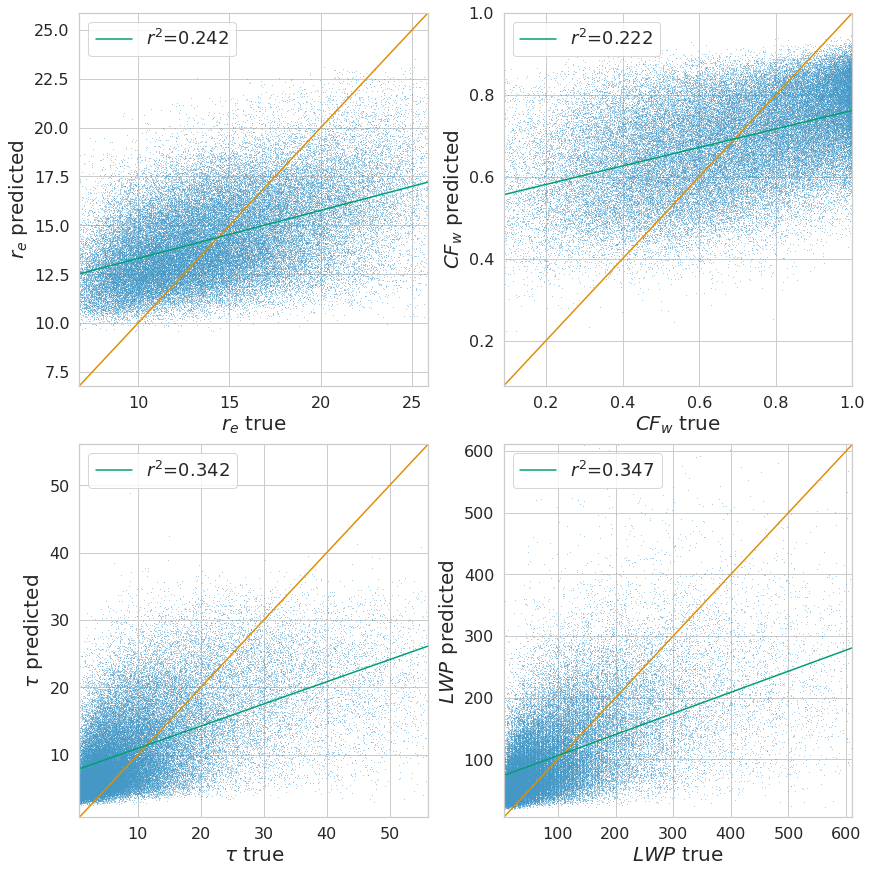

In [10]:
_, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 12))

idx_outcome = 0
qs = np.quantile(observed_outcomes[:, idx_outcome], [0.01, 0.99])
domain = np.arange(qs[0], qs[1], 0.01)
slope, intercept, r, p, stderr = stats.linregress(
    observed_outcomes[:, idx_outcome], means_ensemble.mean(0)[:, idx_outcome]
)
_ = sns.scatterplot(x=observed_outcomes[:, idx_outcome], y=means_ensemble.mean(0)[:, idx_outcome], s=0.5, ax=ax1)
_ = ax1.plot(domain, domain, c="C1")
_ = ax1.plot(domain, domain * slope + intercept, c="C2", label=f"$r^2$={r**2:.03f}")
_ = ax1.set_xlim(qs)
_ = ax1.set_ylim(qs)
_ = ax1.set_xlabel(f"{TARGET_KEYS[idx_outcome]} true")
_ = ax1.set_ylabel(f"{TARGET_KEYS[idx_outcome]} predicted")
_ = ax1.legend(loc="upper left")

idx_outcome = 1
qs = np.quantile(observed_outcomes[:, idx_outcome], [0.01, 0.99])
domain = np.arange(qs[0], qs[1], 0.01)
slope, intercept, r, p, stderr = stats.linregress(
    observed_outcomes[:, idx_outcome], means_ensemble.mean(0)[:, idx_outcome]
)
_ = sns.scatterplot(x=observed_outcomes[:, idx_outcome], y=means_ensemble.mean(0)[:, idx_outcome], s=0.5, ax=ax2)
_ = ax2.plot(domain, domain, c="C1")
_ = ax2.plot(domain, domain * slope + intercept, c="C2", label=f"$r^2$={r**2:.03f}")
_ = ax2.set_xlim(qs)
_ = ax2.set_ylim(qs)
_ = ax2.set_xlabel(f"{TARGET_KEYS[idx_outcome]} true")
_ = ax2.set_ylabel(f"{TARGET_KEYS[idx_outcome]} predicted")
_ = ax2.legend(loc="upper left")

idx_outcome = 2
qs = np.quantile(observed_outcomes[:, idx_outcome], [0.01, 0.99])
domain = np.arange(qs[0], qs[1], 0.01)
slope, intercept, r, p, stderr = stats.linregress(
    observed_outcomes[:, idx_outcome], means_ensemble.mean(0)[:, idx_outcome]
)
_ = sns.scatterplot(x=observed_outcomes[:, idx_outcome], y=means_ensemble.mean(0)[:, idx_outcome], s=0.5, ax=ax3)
_ = ax3.plot(domain, domain, c="C1")
_ = ax3.plot(domain, domain * slope + intercept, c="C2", label=f"$r^2$={r**2:.03f}")
_ = ax3.set_xlim(qs)
_ = ax3.set_ylim(qs)
_ = ax3.set_xlabel(f"{TARGET_KEYS[idx_outcome]} true")
_ = ax3.set_ylabel(f"{TARGET_KEYS[idx_outcome]} predicted")
_ = ax3.legend(loc="upper left")

idx_outcome = 3
qs = np.quantile(observed_outcomes[:, idx_outcome], [0.01, 0.99])
domain = np.arange(qs[0], qs[1], 0.01)
slope, intercept, r, p, stderr = stats.linregress(
    observed_outcomes[:, idx_outcome], means_ensemble.mean(0)[:, idx_outcome]
)
_ = sns.scatterplot(x=observed_outcomes[:, idx_outcome], y=means_ensemble.mean(0)[:, idx_outcome], s=0.5, ax=ax4)
_ = ax4.plot(domain, domain, c="C1")
_ = ax4.plot(domain, domain * slope + intercept, c="C2", label=f"$r^2$={r**2:.03f}")
_ = ax4.set_xlim(qs)
_ = ax4.set_ylim(qs)
_ = ax4.set_xlabel(f"{TARGET_KEYS[idx_outcome]} true")
_ = ax4.set_ylabel(f"{TARGET_KEYS[idx_outcome]} predicted")
_ = ax4.legend(loc="upper left")

## $\Lambda  \to 1.0$

In [ ]:
treatments = np.quantile(
    ds["train"].treatments_xfm.inverse_transform(ds["train"].treatments),
    q=np.arange(0, 1 + 1 / 32, 1 / 32),
)[:-1]
apos_ensemble_path = Path("apos_ensemble.npy")
if not apos_ensemble_path.exists():
    capos_ensemble = ensembles.predict_capos(
        ensemble=ensemble, 
        dataset=ds["test"], 
        treatments=treatments, 
        batch_size=20000,
    )
    apos_ensemble = capos_ensemble.mean(2)
    np.save(apos_ensemble_path, apos_ensemble)
else:
    apos_ensemble = np.load(apos_ensemble_path)

In [ ]:
alpha = 0.05
idx_outcome = 2
_ = sns.lineplot(x=treatments, y=apos_ensemble[idx_outcome].mean(0))
_ = plt.fill_between(
    x=treatments,
    y1=np.quantile(apos_ensemble[idx_outcome], 1 - alpha / 2, axis=0),
    y2=np.quantile(apos_ensemble[idx_outcome], alpha / 2, axis=0),
    alpha=0.2,
    label=r"$\Lambda \to 1.0 $",
)
_ = plt.legend(
    title=r"$\alpha=$" + f"{alpha}",
    loc="upper left",
)
_ = plt.ylabel(TARGET_KEYS[idx_outcome])
_ = plt.xlabel("AOD")

## $\Lambda \to \infty$

In [ ]:
log_lambda = 16.0
apo_limits_infty_path = Path("apo_limits_16.0.npy")
if not apo_limits_infty_path.exists():
    lower_capos, upper_capos = ensembles.predict_intervals(
        ensemble=ensemble,
        dataset=ds["test"],
        treatments=treatments,
        log_lambda=log_lambda,
        num_samples=100,
        batch_size=10000,
    )
    lower_apos = np.expand_dims(lower_capos.mean(2), 0)
    upper_apos = np.expand_dims(upper_capos.mean(2), 0)
    apo_limits_infty = np.concatenate([lower_apos, upper_apos], axis=0)
    np.save(apo_limits_infty_path, apo_limits_infty)
else:
    apo_limits_infty = np.load(apo_limits_infty_path)
ymax = np.quantile(apo_limits_infty[1][idx_outcome], 1 - alpha / 2, axis=0)
ymin = np.quantile(apo_limits_infty[0][idx_outcome], alpha / 2, axis=0)
y_range_limit = ymax - ymin
y_range = np.quantile(apos_ensemble[idx_outcome], 1 - alpha / 2, axis=0) - np.quantile(apos_ensemble[idx_outcome], alpha / 2, axis=0)
rho_0 = y_range / y_range_limit

In [ ]:
alpha = 0.05
idx_outcome = 2
_ = sns.lineplot(x=treatments, y=apos_ensemble[idx_outcome].mean(0))
_ = plt.fill_between(
    x=treatments,
    y1=np.quantile(apos_ensemble[idx_outcome], 1 - alpha / 2, axis=0),
    y2=np.quantile(apos_ensemble[idx_outcome], alpha / 2, axis=0),
    alpha=0.2,
    label=r"$\Lambda \to 1.0 $",
)
_ = plt.fill_between(
    x=treatments,
    y1=np.quantile(apo_limits_infty[1][idx_outcome], 1 - alpha / 2, axis=0),
    y2=np.quantile(apos_ensemble[idx_outcome], 1 - alpha / 2, axis=0),
    alpha=0.2,
    color="C8",
    label=r"$\Lambda \to \infty$",
)
_ = plt.fill_between(
    x=treatments,
    y1=np.quantile(apo_limits_infty[0][idx_outcome], alpha / 2, axis=0),
    y2=np.quantile(apos_ensemble[idx_outcome], alpha / 2, axis=0),
    alpha=0.2,
    color="C8",
)
_ = plt.legend(
    title=r"$\alpha=$" + f"{alpha}",
    loc="upper left",
)
_ = plt.legend(
    title=r"$\alpha=$" + f"{alpha}",
    loc="upper left",
)
_ = plt.ylabel(TARGET_KEYS[idx_outcome])
_ = plt.xlabel("AOD")

## $\Lambda = 1.1$

In [ ]:
log_lambda = 0.1
apo_limits_1_path = Path("apo_limits_0.1.npy")
if not apo_limits_1_path.exists():
    lower_capos, upper_capos = ensembles.predict_intervals(
        ensemble=ensemble,
        dataset=ds["test"],
        treatments=treatments,
        log_lambda=log_lambda,
        num_samples=100,
        batch_size=10000,
    )
    lower_apos = np.expand_dims(lower_capos.mean(2), 0)
    upper_apos = np.expand_dims(upper_capos.mean(2), 0)
    apo_limits_1 = np.concatenate([lower_apos, upper_apos], axis=0)
    np.save(apo_limits_1_path, apo_limits_1)
else:
    apo_limits_1 = np.load(apo_limits_1_path)
y_range = np.quantile(apo_limits_1[1][idx_outcome], 1 - alpha / 2, axis=0) - np.quantile(apo_limits_1[0][idx_outcome], alpha / 2, axis=0)
rho_1 = y_range / y_range_limit

In [ ]:
alpha = 0.05
idx_outcome = 2
_, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
_ = sns.lineplot(x=treatments, y=apos_ensemble[idx_outcome].mean(0), ax=ax1)
_ = ax1.fill_between(
    x=treatments,
    y1=np.quantile(apos_ensemble[idx_outcome], 1 - alpha / 2, axis=0),
    y2=np.quantile(apos_ensemble[idx_outcome], alpha / 2, axis=0),
    alpha=0.2,
    label=r"$\Lambda \to 1.0$",
)
_ = ax1.fill_between(
    x=treatments,
    y1=np.quantile(apo_limits_1[1][idx_outcome], 1 - alpha / 2, axis=0),
    y2=np.quantile(apos_ensemble[idx_outcome], 1 - alpha / 2, axis=0),
    alpha=0.2,
    color="C1",
    label=r"$\Lambda=$" + f"{np.exp(0.1):.01f}",
)
_ = ax1.fill_between(
    x=treatments,
    y1=np.quantile(apo_limits_1[0][idx_outcome], alpha / 2, axis=0),
    y2=np.quantile(apos_ensemble[idx_outcome], alpha / 2, axis=0),
    alpha=0.2,
    color="C1",
)
_ = ax1.legend(
    title=r"$\alpha=$" + f"{alpha}",
    loc="upper left",
)
_ = ax1.set_ylabel(TARGET_KEYS[idx_outcome])
_ = ax1.set_xlabel("AOD")

_ = sns.lineplot(
    x=treatments, 
    y=rho_0, 
    label=r"$\Lambda\to 1.0$",
)
_ = sns.lineplot(
    x=treatments, 
    y=rho_1,
    label=r"$\Lambda=$" + f"{np.exp(0.1):.01f}",
)
_ = ax2.legend(
    title=r"$\alpha=$" + f"{alpha}",
    loc="upper left",
)
_ = ax2.set_ylabel(r"$\rho$")
_ = ax2.set_xlabel("AOD")

In [ ]:
log_lambda = 0.2
apo_limits_2_path = Path("apo_limits_0.2.npy")
if not apo_limits_2_path.exists():
    lower_capos, upper_capos = ensembles.predict_intervals(
        ensemble=ensemble,
        dataset=ds["test"],
        treatments=treatments,
        log_lambda=log_lambda,
        num_samples=100,
        batch_size=10000,
    )
    lower_apos = np.expand_dims(lower_capos.mean(2), 0)
    upper_apos = np.expand_dims(upper_capos.mean(2), 0)
    apo_limits_2 = np.concatenate([lower_apos, upper_apos], axis=0)
    np.save(apo_limits_2_path, apo_limits_2)
else:
    apo_limits_2 = np.load(apo_limits_2_path)
y_range = np.quantile(apo_limits_2[1][idx_outcome], 1 - alpha / 2, axis=0) - np.quantile(apo_limits_2[0][idx_outcome], alpha / 2, axis=0)
rho_2 = y_range / y_range_limit

In [ ]:
alpha = 0.05
idx_outcome = 2
_, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
_ = sns.lineplot(x=treatments, y=apos_ensemble[idx_outcome].mean(0), ax=ax1)
_ = ax1.fill_between(
    x=treatments,
    y1=np.quantile(apos_ensemble[idx_outcome], 1 - alpha / 2, axis=0),
    y2=np.quantile(apos_ensemble[idx_outcome], alpha / 2, axis=0),
    alpha=0.2,
    label=r"$\Lambda \to 1.0$",
)
_ = ax1.fill_between(
    x=treatments,
    y1=np.quantile(apo_limits_1[1][idx_outcome], 1 - alpha / 2, axis=0),
    y2=np.quantile(apos_ensemble[idx_outcome], 1 - alpha / 2, axis=0),
    alpha=0.2,
    color="C1",
    label=r"$\Lambda=$" + f"{np.exp(0.1):.01f}",
)
_ = ax1.fill_between(
    x=treatments,
    y1=np.quantile(apo_limits_1[0][idx_outcome], alpha / 2, axis=0),
    y2=np.quantile(apos_ensemble[idx_outcome], alpha / 2, axis=0),
    alpha=0.2,
    color="C1",
)
_ = ax1.fill_between(
    x=treatments,
    y1=np.quantile(apo_limits_2[1][idx_outcome], 1 - alpha / 2, axis=0),
    y2=np.quantile(apo_limits_1[1][idx_outcome], 1 - alpha / 2, axis=0),
    alpha=0.2,
    color="C2",
    label=r"$\Lambda=$" + f"{np.exp(0.2):.01f}",
)
_ = ax1.fill_between(
    x=treatments,
    y1=np.quantile(apo_limits_2[0][idx_outcome], alpha / 2, axis=0),
    y2=np.quantile(apo_limits_1[0][idx_outcome], alpha / 2, axis=0),
    alpha=0.2,
    color="C2",
)
_ = ax1.legend(
    title=r"$\alpha=$" + f"{alpha}",
    loc="upper left",
)
_ = ax1.set_ylabel(TARGET_KEYS[idx_outcome])
_ = ax1.set_xlabel("AOD")

_ = sns.lineplot(
    x=treatments, 
    y=rho_0, 
    label=r"$\Lambda\to 1.0$",
)
_ = sns.lineplot(
    x=treatments, 
    y=rho_1,
    label=r"$\Lambda=$" + f"{np.exp(0.1):.01f}",
)
_ = sns.lineplot(
    x=treatments, 
    y=rho_2,
    label=r"$\Lambda=$" + f"{np.exp(0.2):.01f}",
)
_ = ax2.legend(
    title=r"$\alpha=$" + f"{alpha}",
    loc="upper left",
)
_ = ax2.set_ylabel(r"$\rho$")
_ = ax2.set_xlabel("AOD")

In [ ]:
log_lambda = 0.5
apo_limits_3_path = Path("apo_limits_0.5.npy")
if not apo_limits_3_path.exists():
    lower_capos, upper_capos = ensembles.predict_intervals(
        ensemble=ensemble,
        dataset=ds["test"],
        treatments=treatments,
        log_lambda=log_lambda,
        num_samples=100,
        batch_size=10000,
    )
    lower_apos = np.expand_dims(lower_capos.mean(2), 0)
    upper_apos = np.expand_dims(upper_capos.mean(2), 0)
    apo_limits_3 = np.concatenate([lower_apos, upper_apos], axis=0)
    np.save(apo_limits_3_path, apo_limits_3)
else:
    apo_limits_3 = np.load(apo_limits_3_path)
y_range = np.quantile(apo_limits_3[1][idx_outcome], 1 - alpha / 2, axis=0) - np.quantile(apo_limits_3[0][idx_outcome], alpha / 2, axis=0)
rho_3 = y_range / y_range_limit

In [ ]:
alpha = 0.05
idx_outcome = 2
_, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
_ = sns.lineplot(x=treatments, y=apos_ensemble[idx_outcome].mean(0), ax=ax1)
_ = ax1.fill_between(
    x=treatments,
    y1=np.quantile(apos_ensemble[idx_outcome], 1 - alpha / 2, axis=0),
    y2=np.quantile(apos_ensemble[idx_outcome], alpha / 2, axis=0),
    alpha=0.2,
    label=r"$\Lambda \to 1.0$",
)
_ = ax1.fill_between(
    x=treatments,
    y1=np.quantile(apo_limits_1[1][idx_outcome], 1 - alpha / 2, axis=0),
    y2=np.quantile(apos_ensemble[idx_outcome], 1 - alpha / 2, axis=0),
    alpha=0.2,
    color="C1",
    label=r"$\Lambda=$" + f"{np.exp(0.1):.01f}",
)
_ = ax1.fill_between(
    x=treatments,
    y1=np.quantile(apo_limits_1[0][idx_outcome], alpha / 2, axis=0),
    y2=np.quantile(apos_ensemble[idx_outcome], alpha / 2, axis=0),
    alpha=0.2,
    color="C1",
)
_ = ax1.fill_between(
    x=treatments,
    y1=np.quantile(apo_limits_2[1][idx_outcome], 1 - alpha / 2, axis=0),
    y2=np.quantile(apo_limits_1[1][idx_outcome], 1 - alpha / 2, axis=0),
    alpha=0.2,
    color="C2",
    label=r"$\Lambda=$" + f"{np.exp(0.2):.01f}",
)
_ = ax1.fill_between(
    x=treatments,
    y1=np.quantile(apo_limits_2[0][idx_outcome], alpha / 2, axis=0),
    y2=np.quantile(apo_limits_1[0][idx_outcome], alpha / 2, axis=0),
    alpha=0.2,
    color="C2",
)
_ = ax1.fill_between(
    x=treatments,
    y1=np.quantile(apo_limits_3[1][idx_outcome], 1 - alpha / 2, axis=0),
    y2=np.quantile(apo_limits_2[1][idx_outcome], 1 - alpha / 2, axis=0),
    alpha=0.2,
    color="C3",
    label=r"$\Lambda=$" + f"{np.exp(0.5):.01f}",
)
_ = ax1.fill_between(
    x=treatments,
    y1=np.quantile(apo_limits_3[0][idx_outcome], alpha / 2, axis=0),
    y2=np.quantile(apo_limits_2[0][idx_outcome], alpha / 2, axis=0),
    alpha=0.2,
    color="C3",
)
_ = ax1.legend(
    title=r"$\alpha=$" + f"{alpha}",
    loc="upper left",
)
_ = ax1.set_ylabel(TARGET_KEYS[idx_outcome])
_ = ax1.set_xlabel("AOD")

_ = sns.lineplot(
    x=treatments, 
    y=rho_0, 
    label=r"$\Lambda\to 1.0$",
)
_ = sns.lineplot(
    x=treatments, 
    y=rho_1,
    label=r"$\Lambda=$" + f"{np.exp(0.1):.01f}",
)
_ = sns.lineplot(
    x=treatments, 
    y=rho_2,
    label=r"$\Lambda=$" + f"{np.exp(0.2):.01f}",
)
_ = sns.lineplot(
    x=treatments, 
    y=rho_3,
    label=r"$\Lambda=$" + f"{np.exp(0.5):.01f}",
)
_ = ax2.legend(
    title=r"$\alpha=$" + f"{alpha}",
    loc="upper left",
)
_ = ax2.set_ylabel(r"$\rho$")
_ = ax2.set_xlabel("AOD")

In [ ]:
log_lambda = 1.0
apo_limits_4_path = Path("apo_limits_1.0.npy")
if not apo_limits_4_path.exists():
    lower_capos, upper_capos = ensembles.predict_intervals(
        ensemble=ensemble,
        dataset=ds["test"],
        treatments=treatments,
        log_lambda=log_lambda,
        num_samples=100,
        batch_size=10000,
    )
    lower_apos = np.expand_dims(lower_capos.mean(2), 0)
    upper_apos = np.expand_dims(upper_capos.mean(2), 0)
    apo_limits_4 = np.concatenate([lower_apos, upper_apos], axis=0)
    np.save(apo_limits_4_path, apo_limits_4)
else:
    apo_limits_4 = np.load(apo_limits_4_path)
y_range = np.quantile(apo_limits_4[1][idx_outcome], 1 - alpha / 2, axis=0) - np.quantile(apo_limits_4[0][idx_outcome], alpha / 2, axis=0)
rho_4 = y_range / y_range_limit

In [ ]:
log_lambda = 2.0
apo_limits_5_path = Path("apo_limits_2.0.npy")
if not apo_limits_5_path.exists():
    lower_capos, upper_capos = ensembles.predict_intervals(
        ensemble=ensemble,
        dataset=ds["test"],
        treatments=treatments,
        log_lambda=log_lambda,
        num_samples=100,
        batch_size=10000,
    )
    lower_apos = np.expand_dims(lower_capos.mean(2), 0)
    upper_apos = np.expand_dims(upper_capos.mean(2), 0)
    apo_limits_5 = np.concatenate([lower_apos, upper_apos], axis=0)
    np.save(apo_limits_5_path, apo_limits_5)
else:
    apo_limits_5 = np.load(apo_limits_5_path)
y_range = np.quantile(apo_limits_5[1][idx_outcome], 1 - alpha / 2, axis=0) - np.quantile(apo_limits_5[0][idx_outcome], alpha / 2, axis=0)
rho_5 = y_range / y_range_limit

In [ ]:
log_lambda = 4.0
apo_limits_6_path = Path("apo_limits_4.0.npy")
if not apo_limits_6_path.exists():
    lower_capos, upper_capos = ensembles.predict_intervals(
        ensemble=ensemble,
        dataset=ds["test"],
        treatments=treatments,
        log_lambda=log_lambda,
        num_samples=100,
        batch_size=10000,
    )
    lower_apos = np.expand_dims(lower_capos.mean(2), 0)
    upper_apos = np.expand_dims(upper_capos.mean(2), 0)
    apo_limits_6 = np.concatenate([lower_apos, upper_apos], axis=0)
    np.save(apo_limits_6_path, apo_limits_6)
else:
    apo_limits_6 = np.load(apo_limits_6_path)
y_range = np.quantile(apo_limits_6[1][idx_outcome], 1 - alpha / 2, axis=0) - np.quantile(apo_limits_6[0][idx_outcome], alpha / 2, axis=0)
rho_6 = y_range / y_range_limit

In [ ]:
log_lambda = 8.0
apo_limits_7_path = Path("apo_limits_8.0.npy")
if not apo_limits_7_path.exists():
    lower_capos, upper_capos = ensembles.predict_intervals(
        ensemble=ensemble,
        dataset=ds["test"],
        treatments=treatments,
        log_lambda=log_lambda,
        num_samples=100,
        batch_size=10000,
    )
    lower_apos = np.expand_dims(lower_capos.mean(2), 0)
    upper_apos = np.expand_dims(upper_capos.mean(2), 0)
    apo_limits_7 = np.concatenate([lower_apos, upper_apos], axis=0)
    np.save(apo_limits_7_path, apo_limits_7)
else:
    apo_limits_7 = np.load(apo_limits_7_path)
y_range = np.quantile(apo_limits_7[1][idx_outcome], 1 - alpha / 2, axis=0) - np.quantile(apo_limits_7[0][idx_outcome], alpha / 2, axis=0)
rho_7 = y_range / y_range_limit

In [ ]:
alpha = 0.05
idx_outcome = 2
_, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
_ = sns.lineplot(x=treatments, y=apos_ensemble[idx_outcome].mean(0), ax=ax1)
_ = ax1.fill_between(
    x=treatments,
    y1=np.quantile(apos_ensemble[idx_outcome], 1 - alpha / 2, axis=0),
    y2=np.quantile(apos_ensemble[idx_outcome], alpha / 2, axis=0),
    alpha=0.2,
    label=r"$\Lambda \to 1.0$",
)
_ = ax1.fill_between(
    x=treatments,
    y1=np.quantile(apo_limits_1[1][idx_outcome], 1 - alpha / 2, axis=0),
    y2=np.quantile(apos_ensemble[idx_outcome], 1 - alpha / 2, axis=0),
    alpha=0.2,
    color="C1",
    label=r"$\Lambda=$" + f"{np.exp(0.1):.01f}",
)
_ = ax1.fill_between(
    x=treatments,
    y1=np.quantile(apo_limits_1[0][idx_outcome], alpha / 2, axis=0),
    y2=np.quantile(apos_ensemble[idx_outcome], alpha / 2, axis=0),
    alpha=0.2,
    color="C1",
)
_ = ax1.fill_between(
    x=treatments,
    y1=np.quantile(apo_limits_2[1][idx_outcome], 1 - alpha / 2, axis=0),
    y2=np.quantile(apo_limits_1[1][idx_outcome], 1 - alpha / 2, axis=0),
    alpha=0.2,
    color="C2",
    label=r"$\Lambda=$" + f"{np.exp(0.2):.01f}",
)
_ = ax1.fill_between(
    x=treatments,
    y1=np.quantile(apo_limits_2[0][idx_outcome], alpha / 2, axis=0),
    y2=np.quantile(apo_limits_1[0][idx_outcome], alpha / 2, axis=0),
    alpha=0.2,
    color="C2",
)
_ = ax1.fill_between(
    x=treatments,
    y1=np.quantile(apo_limits_3[1][idx_outcome], 1 - alpha / 2, axis=0),
    y2=np.quantile(apo_limits_2[1][idx_outcome], 1 - alpha / 2, axis=0),
    alpha=0.2,
    color="C3",
    label=r"$\Lambda=$" + f"{np.exp(0.5):.01f}",
)
_ = ax1.fill_between(
    x=treatments,
    y1=np.quantile(apo_limits_3[0][idx_outcome], alpha / 2, axis=0),
    y2=np.quantile(apo_limits_2[0][idx_outcome], alpha / 2, axis=0),
    alpha=0.2,
    color="C3",
)
_ = ax1.fill_between(
    x=treatments,
    y1=np.quantile(apo_limits_4[1][idx_outcome], 1 - alpha / 2, axis=0),
    y2=np.quantile(apo_limits_3[1][idx_outcome], 1 - alpha / 2, axis=0),
    alpha=0.2,
    color="C4",
    label=r"$\Lambda=$" + f"{np.exp(1.0):.01f}",
)
_ = ax1.fill_between(
    x=treatments,
    y1=np.quantile(apo_limits_4[0][idx_outcome], alpha / 2, axis=0),
    y2=np.quantile(apo_limits_3[0][idx_outcome], alpha / 2, axis=0),
    alpha=0.2,
    color="C4",
)
_ = ax1.fill_between(
    x=treatments,
    y1=np.quantile(apo_limits_5[1][idx_outcome], 1 - alpha / 2, axis=0),
    y2=np.quantile(apo_limits_4[1][idx_outcome], 1 - alpha / 2, axis=0),
    alpha=0.2,
    color="C5",
    label=r"$\Lambda=$" + f"{np.exp(2.0):.01f}",
)
_ = ax1.fill_between(
    x=treatments,
    y1=np.quantile(apo_limits_5[0][idx_outcome], alpha / 2, axis=0),
    y2=np.quantile(apo_limits_4[0][idx_outcome], alpha / 2, axis=0),
    alpha=0.2,
    color="C5",
)
_ = ax1.fill_between(
    x=treatments,
    y1=np.quantile(apo_limits_6[1][idx_outcome], 1 - alpha / 2, axis=0),
    y2=np.quantile(apo_limits_5[1][idx_outcome], 1 - alpha / 2, axis=0),
    alpha=0.2,
    color="C6",
    label=r"$\Lambda=$" + f"{np.exp(4.0):.01f}",
)
_ = ax1.fill_between(
    x=treatments,
    y1=np.quantile(apo_limits_6[0][idx_outcome], alpha / 2, axis=0),
    y2=np.quantile(apo_limits_5[0][idx_outcome], alpha / 2, axis=0),
    alpha=0.2,
    color="C6",
)
_ = ax1.fill_between(
    x=treatments,
    y1=np.quantile(apo_limits_7[1][idx_outcome], 1 - alpha / 2, axis=0),
    y2=np.quantile(apo_limits_6[1][idx_outcome], 1 - alpha / 2, axis=0),
    alpha=0.2,
    color="C7",
    label=r"$\Lambda=$" + f"{np.exp(8.0):.01f}",
)
_ = ax1.fill_between(
    x=treatments,
    y1=np.quantile(apo_limits_7[0][idx_outcome], alpha / 2, axis=0),
    y2=np.quantile(apo_limits_6[0][idx_outcome], alpha / 2, axis=0),
    alpha=0.2,
    color="C7",
)
_ = ax1.fill_between(
    x=treatments,
    y1=np.quantile(apo_limits_infty[1][idx_outcome], 1 - alpha / 2, axis=0),
    y2=np.quantile(apo_limits_7[1][idx_outcome], 1 - alpha / 2, axis=0),
    alpha=0.2,
    color="C8",
    label=r"$\Lambda\to\infty$",
)
_ = ax1.fill_between(
    x=treatments,
    y1=np.quantile(apo_limits_infty[0][idx_outcome], alpha / 2, axis=0),
    y2=np.quantile(apo_limits_7[0][idx_outcome], alpha / 2, axis=0),
    alpha=0.2,
    color="C8",
)
# _ = ax1.legend(
#     title=r"$\alpha=$" + f"{alpha}",
#     # loc="upper right",
# )
_ = ax1.set_ylabel(TARGET_KEYS[idx_outcome])
_ = ax1.set_xlabel("AOD")

_ = sns.lineplot(
    x=treatments, 
    y=rho_0, 
    label=r"$\Lambda\to 1.0$",
)
_ = sns.lineplot(
    x=treatments, 
    y=rho_1,
    label=r"$\log{\Lambda}=0.1$",
)
_ = sns.lineplot(
    x=treatments, 
    y=rho_2,
    label=r"$\log{\Lambda}=0.2$",
)
_ = sns.lineplot(
    x=treatments, 
    y=rho_3,
    label=r"$\log{\Lambda}=0.5$",
)
_ = sns.lineplot(
    x=treatments, 
    y=rho_4,
    label=r"$\log{\Lambda}=1.0$",
)
_ = sns.lineplot(
    x=treatments, 
    y=rho_5,
    label=r"$\log{\Lambda}=2.0$",
)
_ = sns.lineplot(
    x=treatments, 
    y=rho_6,
    label=r"$\log{\Lambda}=4.0$",
)
_ = sns.lineplot(
    x=treatments, 
    y=rho_7,
    label=r"$\log{\Lambda}=8.0$",
)
_ = sns.lineplot(
    x=treatments, 
    y=rho_7,
    label=r"$\Lambda\to\infty$",
)
handles, labels = ax2.get_legend_handles_labels()
ax2.legend(
    handles[::-1], 
    labels[::-1], 
    title=r"$\alpha=$" + f"{alpha}", 
    # loc='right'
)
_ = ax2.set_ylabel(r"$\rho$")
_ = ax2.set_xlabel("AOD")